# Pendulum RL: Parallel Learning 

**Objective:** Train an agent to balance a pendulum using Reinforcement Learning (RL) RLlibs and compare the training speed when using 1 computer (node) versus multiple computers.

**What tools were used:**
- **Ray RLlib:** Parallel reinforcement learning.
- **Gymnasium:** Provides the `Pendulum-v1` environment.
- **Grid5000:** Used to run the training.

## Steps to Run the Experiments

To reproduce these experiments on g5k:

```bash
# 1. Setup the environment ( ONLY for first time)
./setup_env.sh              # Creates virtual environment and installs lib dependencies

# 2. Submit jobs with different configurations
# Format: oarsub -l host=<nodes>/core=<cores>,walltime=<time> "./run_pendulum.sh"
# Example:

oarsub -l host=1/core=4,walltime=00:30:00 "./run_pendulum.sh"   # 1 node, 4 workers
oarsub -l host=2/core=8,walltime=00:30:00 "./run_pendulum.sh"   # 2 nodes, 8 workers

# 3. View final results
ls results_pendulum/        # CSV files with detailed results
```

The `run_pendulum.sh` script automatically:
- Starts a Ray cluster across allocated nodes
- Calculates optimal number of EnvRunners (1 per CPU core)
- Runs training with PPO for 200 iterations
- Saves results to `results_pendulum/`

## 1. Code & Hyperparameters Explained

For the training (`train_pendulum.py`) it was used the **Proximal Policy Optimization (PPO)** algorithm. PPO was chosen because it works very well for continuous control problems like the Pendulum and it's one of the most popular algorithms in the Ray RLib.

### System Architecture: What Ray does
**(DISCLAIMER: The drawing was done using the help of LLM):**

The distributed training system follows this architecture:

```
┌─────────────────────────────────────────────────────────────────────┐
│                         Ray Cluster                                 │
│                                                                     │
│  ┌────────────────┐         ┌────────────────┐                    │
│  │   Node 1       │         │   Node 2       │   (if multi-node)  │
│  │                │         │                │                    │
│  │  ┌──────────┐  │         │  ┌──────────┐  │                    │
│  │  │EnvRunner │◄─┼─────────┼─►│EnvRunner │  │  Collect          │
│  │  │    1     │  │         │  │    5     │  │  experience       │
│  │  └────┬─────┘  │         │  └────┬─────┘  │  in parallel      │
│  │       │        │         │       │        │                    │
│  │  ┌────▼─────┐  │         │  ┌────▼─────┐  │                    │
│  │  │EnvRunner │  │         │  │EnvRunner │  │                    │
│  │  │    2     │  │         │  │    6     │  │                    │
│  │  └────┬─────┘  │         │  └────┬─────┘  │                    │
│  │       │        │         │       │        │                    │
│  │  ┌────▼─────┐  │         │  ┌────▼─────┐  │                    │
│  │  │EnvRunner │  │         │  │EnvRunner │  │                    │
│  │  │    3     │  │         │  │    7     │  │                    │
│  │  └────┬─────┘  │         │  └────┬─────┘  │                    │
│  │       │        │         │       │        │                    │
│  │  ┌────▼─────┐  │         │  ┌────▼─────┐  │                    │
│  │  │EnvRunner │  │         │  │EnvRunner │  │                    │
│  │  │    4     │  │         │  │    8     │  │                    │
│  │  └────┬─────┘  │         │  └────┬─────┘  │                    │
│  │       │        │         │       │        │                    │
│  │       │  Experience Data │       │        │                    │
│  │       └────────┼──────────┼───────┘        │                    │
│  │                │          │                │                    │
│  │       ┌────────▼──────────▼──────┐         │                    │
│  │       │      LEARNER             │         │  Aggregate data   │
│  │       │  (Policy Update)         │         │  Update network   │
│  │       │                          │         │  Broadcast params │
│  │       │  - Combines batches      │         │                    │
│  │       │  - Computes gradients    │         │                    │
│  │       │  - Updates neural net    │         │                    │
│  │       └──────────┬───────────────┘         │                    │
│  │                  │                         │                    │
│  │         Updated Policy Parameters          │                    │
│  │                  │                         │                    │
│  │       ┌──────────▼──────────────────────┐  │                    │
│  │       │  Broadcast to all EnvRunners    │  │                    │
│  │       └─────────────────────────────────┘  │                    │
│  │                                            │                    │
│  └────────────────┘         └────────────────┘                    │
└─────────────────────────────────────────────────────────────────────┘
```

**Explanation:**
1. **EnvRunners** (workers) run environment simulations in parallel, each collecting experience data (states, actions, rewards)
2. **Synchronization barrier**: Wait for all workers to finish their rollouts
3. **Learner** receives all experience batches, aggregates them into one large batch
4. **Policy update**: Learner runs PPO optimization on the batch, updating the neural network
5. **Broadcast**: Updated (same) policy parameters are sent back to all EnvRunners
6. **Repeat** for the next iteration

**Bottlenecks:**
- **Single-node**: Minimal overhead (shared memory communication)
- **Multi-node**: Network communication between nodes adds latency (experience data + policy parameters must travel over network)

### Reward Metric

The Pendulum-v1 environment uses a **reward function**.
The reward function is defined as:

$$
r = -\left( \text{theta}^2 + 0.1 \, \text{thetadt}^2 + 0.001 \, \text{torque}^2 \right)
$$

where theta is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position). Based on the above equation, the minimum reward that can be obtained is -(pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

- **Good performance**: rewards close to **-200 to -150** per episode (200 timesteps)

Our goal is to maximize the reward (meaning: make it as close to 0 as possible).

### Design Decisions

1.  **Distributed Sampling (`env_runners`)**:
    *   In the example slides from the course, the "EnvRunner" and "Learner" logic was done manually.
    *   **Doing with RLlib automatically.** We just set `num_env_runners`.
    *   **Reason** It reduces code complexity (less lines of code). Ray automatically creates the actor processes and manages communication.

2.  **Hyperparameters** (Selected after multiple tests):
    After testing **multiple configurations** with varying learning rates (0.0003, 0.0001, 0.00005), batch sizes (4000, 8000, 12000), gamma values (0.95, 0.9, 0.85), network sizes ([128, 128], [256, 256], [512, 256]), and other parameters, the following configuration **consistently achieved the best final rewards** (closest to 0):

    | Parameter | Value | Reason |
    | :--- | :--- | :--- |
    | **`train_batch_size`** | `8000` | Large batches provide more stable gradients, helping PPO avoid destructive policy updates. Tested 4000/8000/12000; 8000 gave best stability/speed tradeoff. |
    | **`minibatch_size`** | `64` | Smaller minibatches allow more gradient steps per batch, improving sample efficiency. Tested 128/64/32; 64 balanced convergence speed. |
    | **`lr` (Learning Rate)** | `0.0001` | Lower than typical defaults. Testing showed 0.0001 converges more reliably than 0.0003 for this task without overshooting. |
    | **`gamma` (Discount Factor)** | `0.9` | Pendulum is a short-horizon task. Lower gamma (0.9 vs 0.95/0.99) helps the agent focus on immediate balance rather than distant future. |
    | **`num_epochs`** | `5` | Number of passes through the batch data. 5 epochs maximizes learning from each batch without overfitting. |
    | **`fcnet_hiddens`** | `[256, 256]` | Neural network architecture: 2 hidden layers with 256 neurons each. Sufficient capacity for the continuous control policy without being oversized. |
    | **`num_env_runners`** | `2` or `4` | Parallel workers collect experience simultaneously, speeding up data collection proportionally. |
    | **`num_envs_per_env_runner`** | `4` | Each worker simulates 4 environments in parallel, increasing throughput. |
    | **`clip_param`** | `0.2` | PPO clipping parameter to prevent large policy updates. Standard value that worked well. |
    | **`entropy_coeff`** | `0.001` | Small entropy bonus encourages exploration without destabilizing learning. |

    **Disclaimer:** Not all the possible configurations were tested, this was done by try and error starting from a already tunned example available at Ray RLib and changing the values individually to achieve the best final reward possible while also trying not to exceed a considerable amount of time per iteration.

## 2. Performance Analysis: Scaling with Parallelism

We ran extensive experiments with different parallelism configurations to understand how distributed training affects performance. The conclusion: **parallelism helps, but there's overhead**.

### Experimental Setup

Each configuration was tested with:
- **1, 2, and 4 nodes** (hosts/computers)
- **Varying numbers of EnvRunners** (workers): 1(no CPU parallelism for 1 node), 2, 4, 8, 16, 32
- **200 iterations** of training
- **Fixed hyperparameters** (as described above)

The script automatically allocates **one EnvRunner per CPU core**, so requesting more cores = more parallel workers collecting experience.

As shown before, In distributed PPO with RLlib:
1. **EnvRunners (Workers)**: Run environment simulations in parallel, collecting experience data (observations, actions, rewards).
2. **Learner**: Receives batches from all workers, aggregates them, and updates the neural network policy.
3. **Synchronization**: All workers must finish their rollouts before the learner can start updating.

**This means that** more workers → faster data collection → faster training (but only if communication overhead is not too much).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# all training results
df = pd.read_csv('results_pendulum/all_runs.csv')

# show results
print("All Training Runs:")
print("=" * 100)
display(df[['num_nodes', 'num_env_runners', 'total_cpus', 'num_iterations', 
            'total_time_seconds', 'time_per_iteration', 'final_reward']].sort_values(['num_nodes', 'num_env_runners']).round(2))

print("\n" + "=" * 100)
print(f"Total runs: {len(df)}")

All Training Runs:


,num_nodes,num_env_runners,total_cpus,num_iterations,total_time_seconds,time_per_iteration,final_reward
0,1,1,64,200,1702.34,8.51,-158.35
1,1,2,64,200,1312.32,6.56,-171.20
2,1,4,64,200,1246.26,6.23,-477.20
3,1,8,64,200,1252.08,6.26,-195.52
6,1,32,64,200,1228.13,6.14,-392.15
8,2,2,128,200,1681.07,8.41,-188.99
4,2,4,128,200,1334.77,6.67,-171.71
5,2,8,128,200,1154.96,5.77,-128.56
7,2,32,128,200,1378.13,6.89,-453.04
9,4,8,256,200,1328.52,6.64,-194.70



Total runs: 11


### Visualizing Performance Across Configurations

These charts show how training time varies with different parallelism levels:

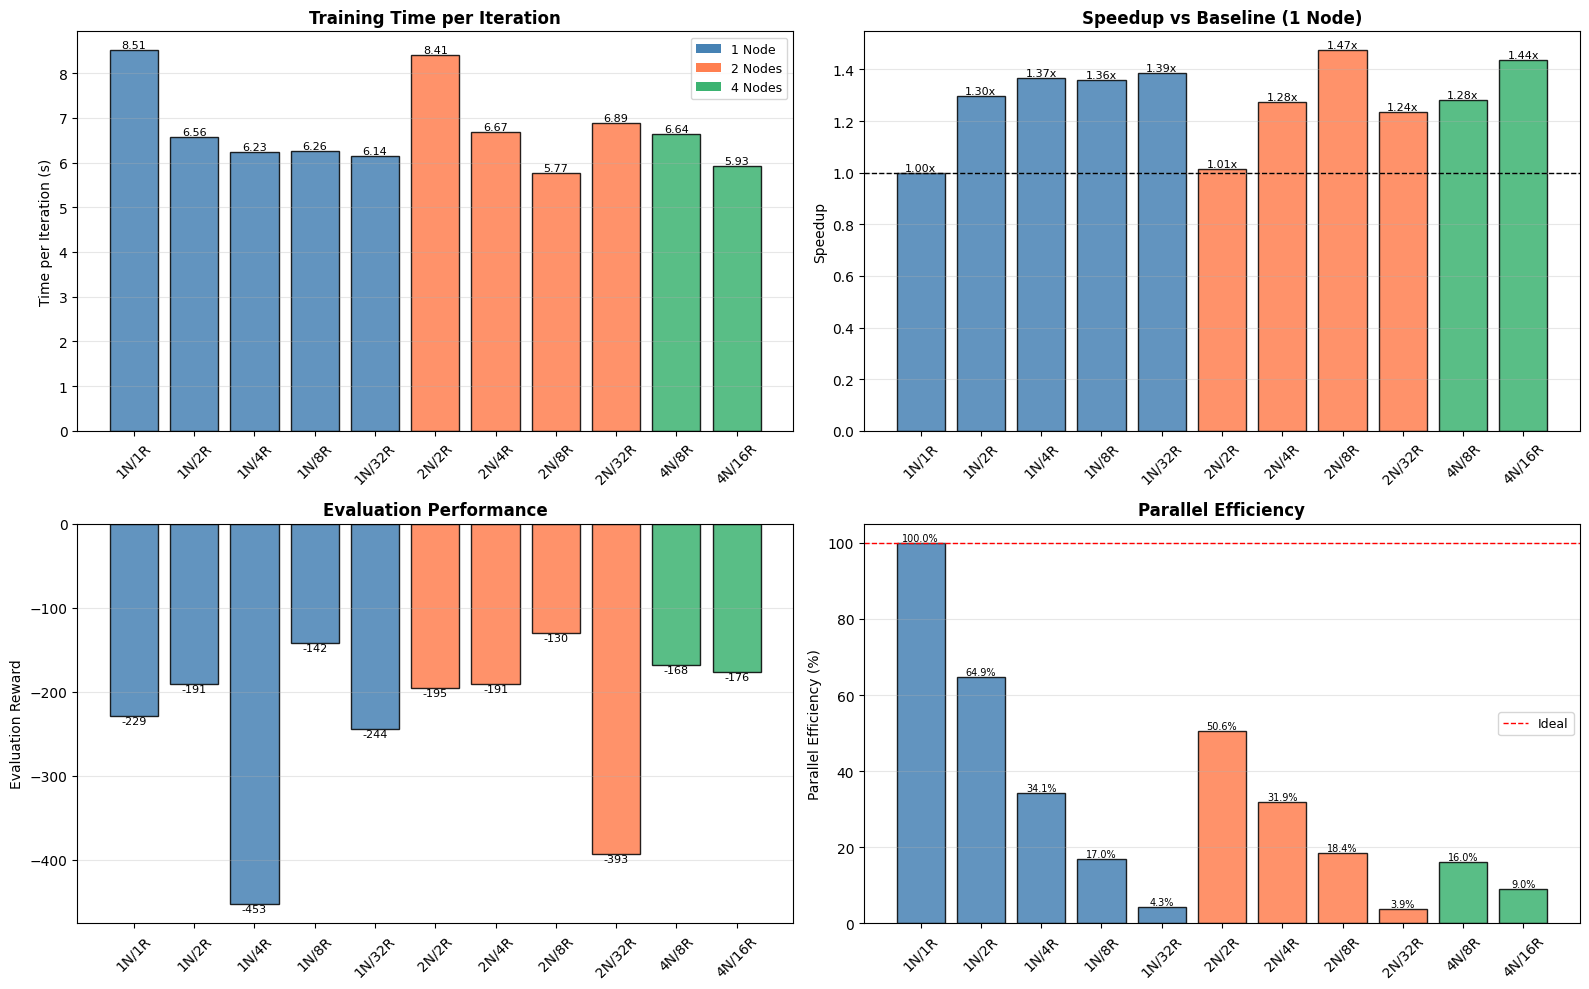

In [ ]:
# all training results
df = pd.read_csv('results_pendulum/all_runs.csv')

# build readable config label
df["config"] = (
    df["num_nodes"].astype(str) + "N/"
    + df["num_env_runners"].astype(str) + "R"
)

# Sort for nicer visualization
viz = df.sort_values(["num_nodes", "num_env_runners"])


color_map = {
    1: "steelblue",
    2: "coral",
    4: "mediumseagreen"
}
colors = [color_map.get(n, "gray") for n in viz["num_nodes"]]

# Baseline: first 1-node run 
baseline_time = viz[viz["num_nodes"] == 1]["time_per_iteration"].iloc[0]
viz["speedup"] = baseline_time / viz["time_per_iteration"]
viz["efficiency"] = viz["speedup"] / viz["num_env_runners"] * 100


# Create figure
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time per iteration
ax1 = axes[0, 0]
bars = ax1.bar(viz["config"], viz["time_per_iteration"],
               color=colors, edgecolor="black", alpha=0.85)
ax1.set_ylabel("Time per Iteration (s)")
ax1.set_title("Training Time per Iteration", fontweight="bold")
ax1.bar_label(bars, fmt="%.2f", fontsize=8)
ax1.tick_params(axis="x", rotation=45)
ax1.grid(axis="y", alpha=0.3)


legend_elements = [
    Patch(facecolor=color_map[1], label="1 Node"),
    Patch(facecolor=color_map[2], label="2 Nodes"),
    Patch(facecolor=color_map[4], label="4 Nodes"),
]
ax1.legend(handles=legend_elements, fontsize=9)

# Plot 2: Speedup
ax2 = axes[0, 1]
bars = ax2.bar(viz["config"], viz["speedup"],
               color=colors, edgecolor="black", alpha=0.85)
ax2.axhline(1.0, linestyle="--", color="black", linewidth=1)
ax2.set_ylabel("Speedup")
ax2.set_title("Speedup vs Baseline (1 Node)", fontweight="bold")
ax2.bar_label(bars, fmt="%.2fx", fontsize=8)
ax2.tick_params(axis="x", rotation=45)
ax2.grid(axis="y", alpha=0.3)

# Plot 3: Evaluation reward
ax3 = axes[1, 0]
bars = ax3.bar(viz["config"], viz["eval_reward"],
               color=colors, edgecolor="black", alpha=0.85)
ax3.set_ylabel("Evaluation Reward")
ax3.set_title("Evaluation Performance", fontweight="bold")
ax3.bar_label(bars, fmt="%.0f", fontsize=8)
ax3.tick_params(axis="x", rotation=45)
ax3.grid(axis="y", alpha=0.3)

# Plot 4: Parallel efficiency
ax4 = axes[1, 1]
bars = ax4.bar(viz["config"], viz["efficiency"],
               color=colors, edgecolor="black", alpha=0.85)
ax4.axhline(100, linestyle="--", color="red", linewidth=1, label="Ideal")
ax4.set_ylabel("Parallel Efficiency (%)")
ax4.set_title("Parallel Efficiency", fontweight="bold")
ax4.bar_label(bars, fmt="%.1f%%", fontsize=7)
ax4.tick_params(axis="x", rotation=45)
ax4.grid(axis="y", alpha=0.3)
ax4.legend(fontsize=9)

plt.tight_layout()
plt.savefig("results_pendulum_try/performance_comparison.png",
            dpi=150, bbox_inches="tight")
plt.show()

## 3. Analysis: Parallelism and Performance

The results show that adding parallelism for the Pendulum environment has **limited returns**, both within a single node and also with multiple nodes.

### Single-Node Scaling (1N)
Increasing the number of EnvRunners from **1 to 2** reduces training time per iteration from **~8.5 s to ~6.6 s**, corresponding to a **1.3× speedup** instead of the ideal 2×. Further increases show almost no benefit:
- **4 EnvRunners:** ~6.2 s  
- **8 EnvRunners:** ~6.3 s  
- **32 EnvRunners:** ~6.1 s  

Beyond **4 EnvRunners**, performance effectively stops improving, indicating that parallel rollout collection is no longer the dominant cost.

### Multi-Node Scaling
Scalling up to 2 nodes provides **some improvements** but further increases show no actuall benefit:
- **1N/8R:** ~6.3 s  
- **2N/8R:** ~5.8 s (best observed)  
- **4N/8R:** ~6.6 s (worse than single-node)

Several multi-node configurations are slower than their single-node counterparts, showing that **in this case, network communication and synchronization overhead end up diminishing the benefits of additional resources**.

### Speedup and Efficiency
- Maximum observed speedup is **~1.5×** (2N/8R).

- Parallel efficiency drops sharply as workers increase:
  - **1N/2R:** ~65% efficiency  
  - **1N/4R:** ~34%  
  - **1N/8R:** ~17%  
  - **32 runners:** <5%

This behavior is consistent with **Amdahl’s Law**, suggesting that a large fraction of each training iteration is still sequential and can't be parallelized.

### Performance vs Speed Trade-off
Even tough the speed performance remains not too different across different configurations, there are still modest gains from parallelization. While some high-parallelism runs do not dramatically improve evaluation rewards, there is a slight benefit in iteration speed: for example, 1 node with 1 core takes 8.51 seconds per iteration, 1 node with 2 cores takes 6.56 seconds, and 2 nodes with 8 runners take 5.77 seconds per iteration. This demonstrates that even modest parallelization can improve throughput without significantly affecting learning outcomes.

### Key Takeaways
- The Pendulum environment is **too lightweight** to benefit significantly from large-scale parallelism.
- The main bottleneck lies in **sequential learner computation, synchronization, and framework overhead**, not data collection - what we mainly parallelize with Ray RLlib.
- **Best efficiency:** 1 node with 2 EnvRunners. 
- **Best absolute time and reward:** 2 nodes with 8 EnvRunners ( ~1.5× speedup and best reward achieved - closest to 0).

**Conclusion:**  
For simple environments like Pendulum, distributed RL provides minimal benefit. Moderate parallelism (2–4 workers on a single node) achieves the best balance between speed and efficiency, while aggressive multi-node scaling leads to wasted resources with little performance gain.


## 4. Technical Notes & Warnings

During execution, several warnings were generated in the stderr logs. These are expected and do not affect the validity of the results:

### Deprecation Warnings
- **RayDeprecationWarning (UnifiedLogger, JsonLogger, CSVLogger, TBXLogger)**: indicate that the logging interfaces will change in future versions, but the current implementation works correctly.
- **Ray GPU environment variable override**: Warning about future behavior changes for GPU environment variables when `num_gpus=0`. Since we did not use GPUs, this has no impact.

### Configuration Warnings
- **Evaluation interval warning**: The script sets `evaluation_num_env_runners=1` but `evaluation_interval=None`, meaning automatic evaluation is disabled. We manually call `evaluate()` after training, so this is intentional.

### Python Package Warnings
- **Pandas version warnings** (numexpr, bottleneck): Minor compatibility notices about auxiliary libraries being slightly outdated. All core functionality works correctly.

**Summary**: All warnings are non-critical. The training runs completed successfully with valid results. The deprecation warnings were not addressed simply because of time constraints and difficulty (5hour long wait times) on running more jobs on the platform in the last 2 days.